In [ ]:
from google.colab import drive
import tensorflow as tf
import numpy as np
import shutil
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, balanced_accuracy_score,
    roc_auc_score, roc_curve, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
import torch
import timm
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
from transformers import ViTForImageClassification, AutoImageProcessor, AutoProcessor, AutoModelForImageClassification

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. Configuration

In [ ]:
# ---- config ----
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "google/vit-base-patch16-224"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 7

LR = 5e-6
WEIGHT_DECAY = 0.01

train_dir = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/train'
val_dir ='/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data/val'
BEST_DIR = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/vit_binary_classification'


# 2 . process dataset

In [ ]:
# ---- processor (get correct mean/std) ----
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
mean = processor.image_mean
std = processor.image_std

# ---- transforms ----
# train_tfms = transforms.Compose([
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.RandomHorizontalFlip(),
#     #transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
#     transforms.RandomRotation(2),
#     # transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=mean, std=std),
# ])

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(
        IMG_SIZE,
        scale=(0.9, 1.0),
        ratio=(0.9, 1.1)
    ),

    transforms.RandomHorizontalFlip(p=0.5),

    transforms.ColorJitter(
        brightness=0.15,
        contrast=0.15,
        saturation=0.1,
        hue=0.02
    ),

    transforms.RandomRotation(3),

    transforms.ToTensor(),

    transforms.Normalize(mean=mean, std=std),
])

val_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


# 3. Load Datasets

In [ ]:
# ---- datasets ----
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)
print("class_to_idx:", train_ds.class_to_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

Classes: ['ai', 'nature']
class_to_idx: {'ai': 0, 'nature': 1}


# 4. Initialize Model

In [ ]:
# ---- model ---
# label2id / id2label
id2label = {id: label for id, label in enumerate(train_ds.classes)}
label2id = {label: id for id, label in enumerate(train_ds.classes)}
print("id2label:", id2label)
print("label2id:", label2id)

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # 让分类头自动重建
).to(DEVICE)

# 1️⃣ 冻结全部
for param in model.parameters():
    param.requires_grad = False

# 2️⃣ 解冻最后5层
for param in model.vit.encoder.layer[-10:].parameters():
    param.requires_grad = True

# 3️⃣ 解冻分类头（必须）
for param in model.classifier.parameters():
    param.requires_grad = True

# 4️⃣ 再创建 optimizer（只给可训练参数）

criterion = nn.CrossEntropyLoss(label_smoothing=0.01)
# optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

optimizer = AdamW([
    {"params": model.classifier.parameters(), "lr": 3e-5},
    {"params": model.vit.encoder.layer[-10:].parameters(), "lr": 1e-5},
], weight_decay=0.01)


id2label: {0: 'ai', 1: 'nature'}
label2id: {'ai': 0, 'nature': 1}


Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 768]) vs model:torch.Size([2, 768])
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([2])          

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


In [ ]:
trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())

print("Trainable params:", trainable)
print("Total params:", total)
print("Trainable %:", 100 * trainable / total)

Trainable params: 70880258
Total params: 85800194
Trainable %: 82.61083652095239


# 6. Training

In [ ]:
print("\n" + "="*60)
print("TRAINING................")
print("="*60)

epochs = 10
train_losses = []
train_accs = []
val_accs = []
val_losses = []

patience = 3
best_val_acc = float("-inf")
best_val_loss = float("inf")
best_epoch = 0
wait = 0  # ✅ 必须初始化

os.makedirs(BEST_DIR, exist_ok=True)

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training
    model.train()
    train_correct = 0
    train_total = 0
    train_loss_sum = 0.0  # 按样本加权累计

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(DEVICE, non_blocking=True)
        batch_y = batch_y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(pixel_values=batch_X)
        logits = outputs.logits

        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        bs = batch_X.size(0)
        train_loss_sum += loss.item() * bs

        preds = logits.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += bs

    train_acc = train_correct / train_total
    avg_train_loss = train_loss_sum / train_total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(DEVICE, non_blocking=True)
            batch_y = batch_y.to(DEVICE, non_blocking=True)

            outputs = model(pixel_values=batch_X)
            logits = outputs.logits

            loss = criterion(logits, batch_y)

            bs = batch_X.size(0)
            val_loss_sum += loss.item() * bs

            preds = logits.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += bs

    val_acc = val_correct / val_total
    avg_val_loss = val_loss_sum / val_total

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch}/{epochs} - Time: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")

    # save best model (based on val_loss)
    improved = val_acc > best_val_acc + 1e-6
    if improved:
        best_val_acc= val_acc
        best_epoch = epoch
        wait = 0
        model.save_pretrained(BEST_DIR)
        processor.save_pretrained(BEST_DIR)
        print(f"best epoch updated to {best_epoch}")
        print(f"best validation acc updated to {best_val_loss:.4f}")
        print(f"best model saved at path {BEST_DIR}")
    else:
        wait += 1
        print(f"val acc did not improve (wait={wait}/{patience})")  # ✅ 文案修正

    # early stop
    if wait >= patience:
        print(f"Early stopping at epoch {epoch}")
        print(f"Best epoch: {best_epoch}")
        print(f"Best val acc: {best_val_acc:.4f}")  # ✅ 修正
        break

print("\n✓ Training complete!")


TRAINING................

Epoch 1/10 - Time: 500.8s (8.3 min)
  Train - Loss: 0.4102, Acc: 0.8108 (81.08%)
  Val   - Loss: 0.3354, Acc: 0.8678 (86.78%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 1
best validation acc updated to inf
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit

Epoch 2/10 - Time: 404.9s (6.7 min)
  Train - Loss: 0.2283, Acc: 0.9166 (91.66%)
  Val   - Loss: 0.2816, Acc: 0.8922 (89.22%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 2
best validation acc updated to inf
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit

Epoch 3/10 - Time: 404.4s (6.7 min)
  Train - Loss: 0.1510, Acc: 0.9531 (95.31%)
  Val   - Loss: 0.2597, Acc: 0.9009 (90.09%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 3
best validation acc updated to inf
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit

Epoch 4/10 - Time: 404.7s (6.7 min)
  Train - Loss: 0.1011, Acc: 0.9747 (97.47%)
  Val   - Loss: 0.2792, Acc: 0.9020 (90.20%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 4
best validation acc updated to inf
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit

Epoch 5/10 - Time: 403.7s (6.7 min)
  Train - Loss: 0.0717, Acc: 0.9864 (98.64%)
  Val   - Loss: 0.2830, Acc: 0.9069 (90.69%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 5
best validation acc updated to inf
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit

Epoch 6/10 - Time: 404.7s (6.7 min)
  Train - Loss: 0.0587, Acc: 0.9916 (99.16%)
  Val   - Loss: 0.2976, Acc: 0.9048 (90.48%)
val acc did not improve (wait=1/3)

Epoch 7/10 - Time: 400.3s (6.7 min)
  Train - Loss: 0.0479, Acc: 0.9957 (99.57%)
  Val   - Loss: 0.3031, Acc: 0.9089 (90.89%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 7
best validation acc updated to inf
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit

Epoch 8/10 - Time: 404.4s (6.7 min)
  Train - Loss: 0.0469, Acc: 0.9955 (99.55%)
  Val   - Loss: 0.3349, Acc: 0.9036 (90.36%)
val acc did not improve (wait=1/3)

Epoch 9/10 - Time: 399.9s (6.7 min)
  Train - Loss: 0.0437, Acc: 0.9969 (99.69%)
  Val   - Loss: 0.3025, Acc: 0.9103 (91.03%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 9
best validation acc updated to inf
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_vit

Epoch 10/10 - Time: 404.4s (6.7 min)
  Train - Loss: 0.0416, Acc: 0.9972 (99.72%)
  Val   - Loss: 0.3159, Acc: 0.9091 (90.91%)
val acc did not improve (wait=1/3)

✓ Training complete!


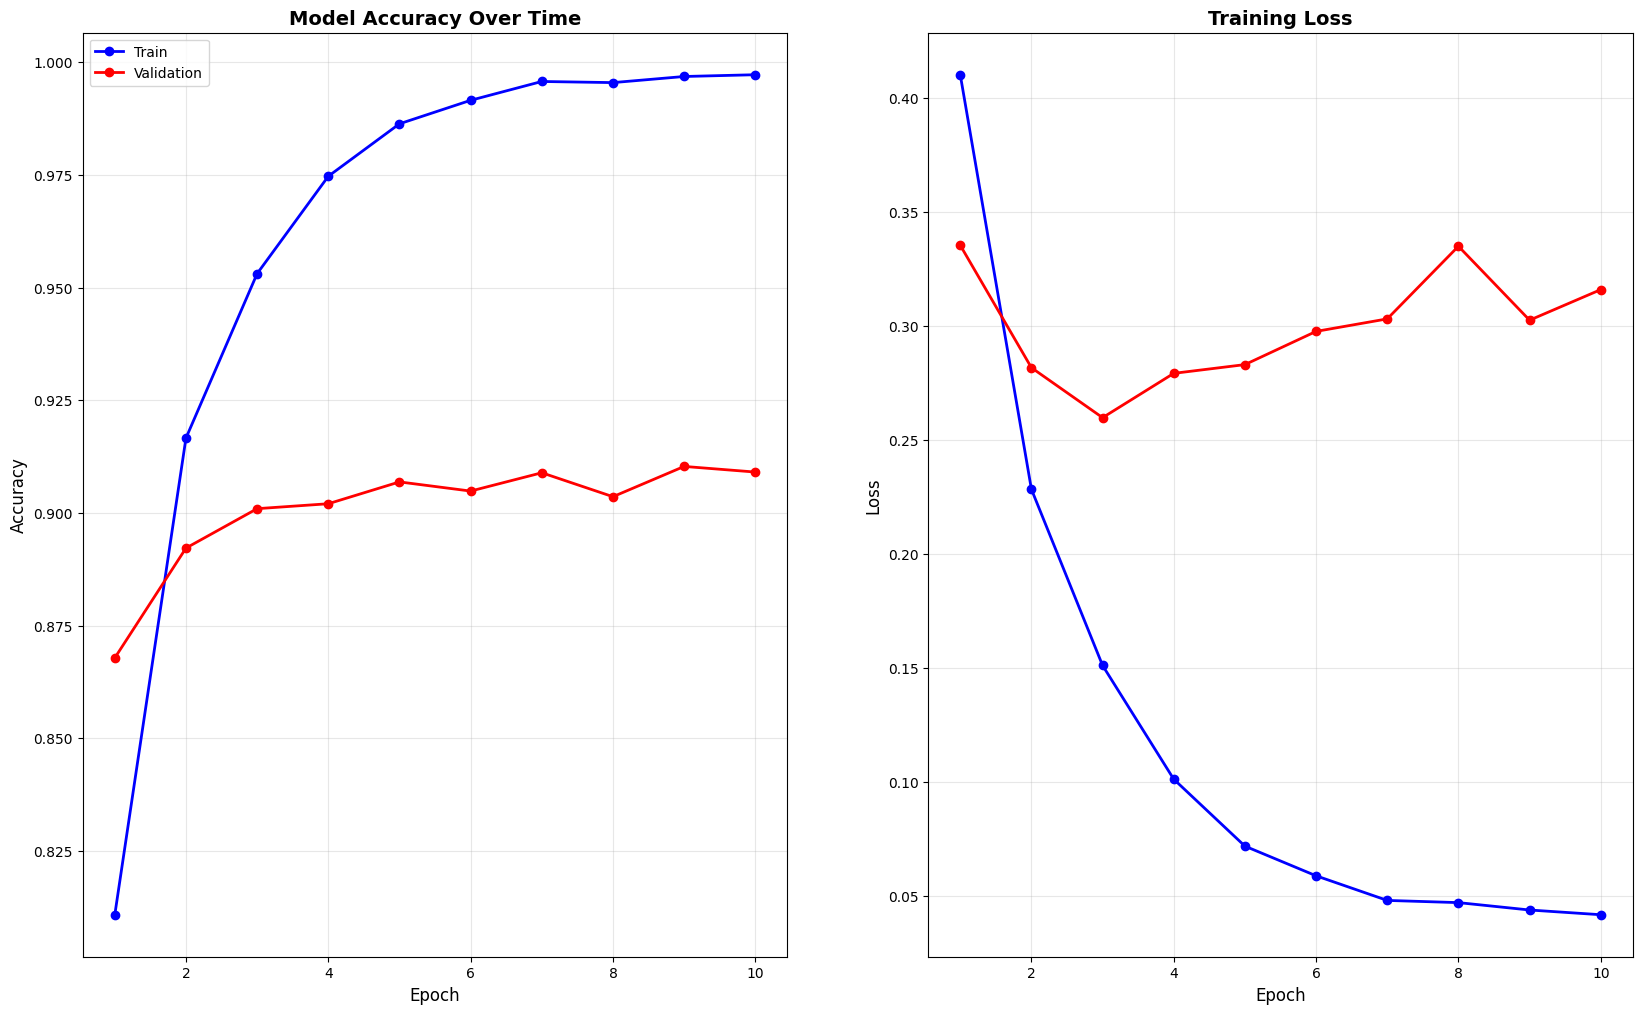

In [ ]:
fig = plt.figure(figsize=(20, 12))

# # 1. Training History
ax1 = plt.subplot(1, 2, 1)
epochs_range = range(1, epochs + 1)
ax1.plot(epochs_range, train_accs, 'b-o', label='Train', linewidth=2)
ax1.plot(epochs_range, val_accs, 'r-o', label='Validation', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

 # 2. Loss Curve
ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs_range, train_losses, 'b-o', linewidth=2)
ax2.plot(epochs_range, val_losses, 'r-o', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training Loss', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)


# 7. Load model

In [ ]:
# 1) Load the model from local
processor = AutoProcessor.from_pretrained(BEST_DIR)
model = AutoModelForImageClassification.from_pretrained(BEST_DIR).to(DEVICE)
model.eval()

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

# 8. Evaluation

In [ ]:
# COMPREHENSIVE EVALUATION
print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION")
print("="*60)

model.eval()

# Get predictions and probabilities
all_predictions = []
all_probabilities = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(DEVICE)
        outputs = model(pixel_values=batch_X)
        # Get probabilities
        probs = torch.softmax(outputs.logits, dim=1)
        all_probabilities.extend(probs[:,1].cpu().numpy())  # prob %

        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1) # 0, 1
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)
print("Evaluation done ! ")


COMPREHENSIVE EVALUATION
Evaluation done ! 


In [ ]:
test_dir = "/content/drive/MyDrive/Colab Notebooks/AI_vs_human/test_binary_classification"
test_ds = datasets.ImageFolder(test_dir, transform=train_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# COMPREHENSIVE EVALUATION
print("\n" + "="*60)
print("COMPREHENSIVE EVALUATION")
print("="*60)

model.eval()

# Get predictions and probabilities
all_predictions = []
all_probabilities = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(DEVICE)
        outputs = model(pixel_values=batch_X)
        # Get probabilities
        probs = torch.softmax(outputs.logits, dim=1)
        all_probabilities.extend(probs[:,1].cpu().numpy())  # prob %

        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1) # 0, 1
        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

all_predictions = np.array(all_predictions)
all_probabilities = np.array(all_probabilities)
all_labels = np.array(all_labels)
print("Evaluation done ! ")


COMPREHENSIVE EVALUATION
Evaluation done ! 


# 9. Performance Metrics

In [ ]:
# ============================================
# METRICS
# ============================================

accuracy = accuracy_score(all_labels, all_predictions)
balanced_acc = balanced_accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions)
recall = recall_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions)
auc = roc_auc_score(all_labels, all_probabilities)

print(f"\n CORE METRICS:")
print(f"   Accuracy:          {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Balanced Accuracy: {balanced_acc:.4f} ({balanced_acc*100:.2f}%)")
print(f"   Precision:         {precision:.4f} ({precision*100:.2f}%)")
print(f"   Recall:            {recall:.4f} ({recall*100:.2f}%)")
print(f"   F1-Score:          {f1:.4f}")
print(f"   ROC-AUC:           {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
tn, fp, fn, tp = cm.ravel()

print(f"\n🔍 CONFUSION MATRIX:")
print(f"   True Negatives (AI→AI):  {tn:4d}")
print(f"   False Positives (AI -> NATURE):     {fp:4d}")
print(f"   False Negatives (NATURE → AI):     {fn:4d}")
print(f"   True Positives (Nature → Nature):          {tp:4d}")

# Per-class metrics
specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0

print(f"\n📈 CLASS-SPECIFIC PERFORMANCE:")
print(f"   Sensitivity (AI detection):     {sensitivity:.4f} ({sensitivity*100:.2f}%)")
print(f"   Specificity (Nature detection): {specificity:.4f} ({specificity*100:.2f}%)")

# Classification Report
print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print(classification_report(all_labels, all_predictions,
                            target_names=['AI', 'NATURE'],
                            digits=4))



 CORE METRICS:
   Accuracy:          0.9067 (90.67%)
   Balanced Accuracy: 0.9067 (90.67%)
   Precision:         0.8987 (89.87%)
   Recall:            0.9167 (91.67%)
   F1-Score:          0.9076
   ROC-AUC:           0.9591

🔍 CONFUSION MATRIX:
   True Negatives (AI→AI):   269
   False Positives (AI -> NATURE):       31
   False Negatives (NATURE → AI):       25
   True Positives (Nature → Nature):           275

📈 CLASS-SPECIFIC PERFORMANCE:
   Sensitivity (AI detection):     0.9167 (91.67%)
   Specificity (Nature detection): 0.8967 (89.67%)

📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

          AI     0.9150    0.8967    0.9057       300
      NATURE     0.8987    0.9167    0.9076       300

    accuracy                         0.9067       600
   macro avg     0.9068    0.9067    0.9067       600
weighted avg     0.9068    0.9067    0.9067       600



# 10. Visualization results

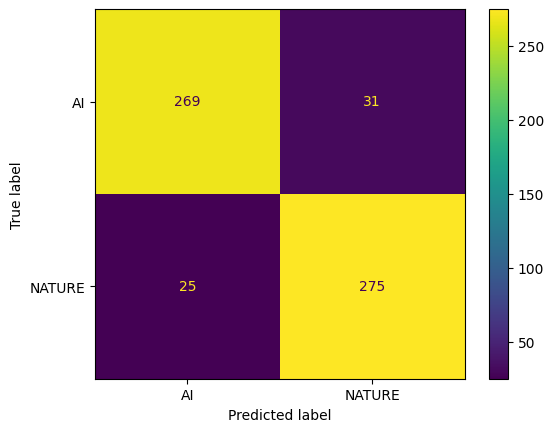

In [ ]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['AI','NATURE'])
plt.text
disp.plot()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/AI_vs_human/confusion_matrix.png', dpi=300,)
plt.show()

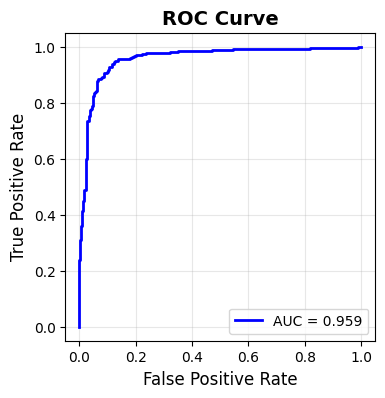

In [ ]:
# ROC Curve
# 4. ROC Curve
plt.figure(figsize=(4, 4))
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc:.3f}')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()

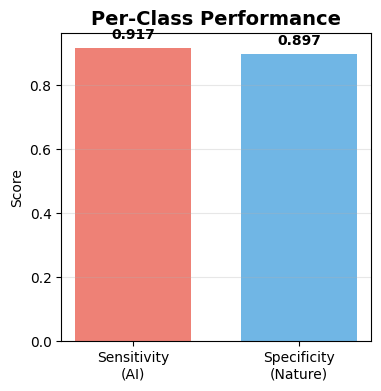

In [ ]:
# 6. Per-Class Performance
plt.figure(figsize=(4, 4))
class_metrics = ['Sensitivity\n(AI)', 'Specificity\n(Nature)']
class_values = [sensitivity, specificity]
class_colors = ['#e74c3c', '#3498db']
bars = plt.bar(class_metrics, class_values,color = class_colors,align='center',alpha = 0.7,width=0.7)
plt.ylabel("Score")
plt.title('Per-Class Performance', fontsize=14, fontweight='bold')
for bar, val in zip(bars,class_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
plt.grid(axis = 'y',alpha=0.3)
plt.show()

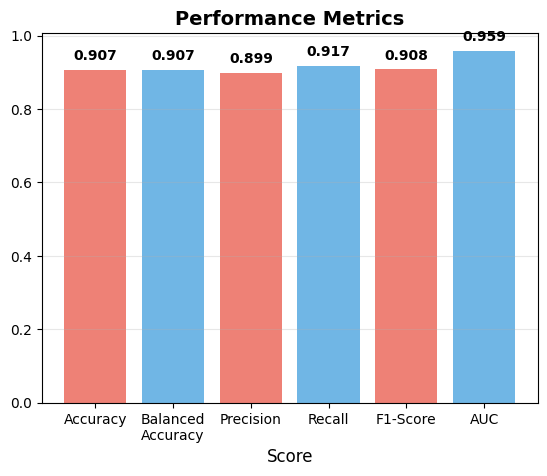

In [ ]:
metrics_names = ['Accuracy', 'Balanced\nAccuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [accuracy, balanced_acc, precision, recall, f1, auc]
bars = plt.bar(metrics_names,metrics_values, color=class_colors, alpha=0.7, align='center')
plt.xlabel('Score', fontsize=12)
plt.title('Performance Metrics', fontsize=14, fontweight='bold')
for bar, val in zip(bars , metrics_values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
plt.grid(axis = 'y',alpha=0.3)
plt.show()


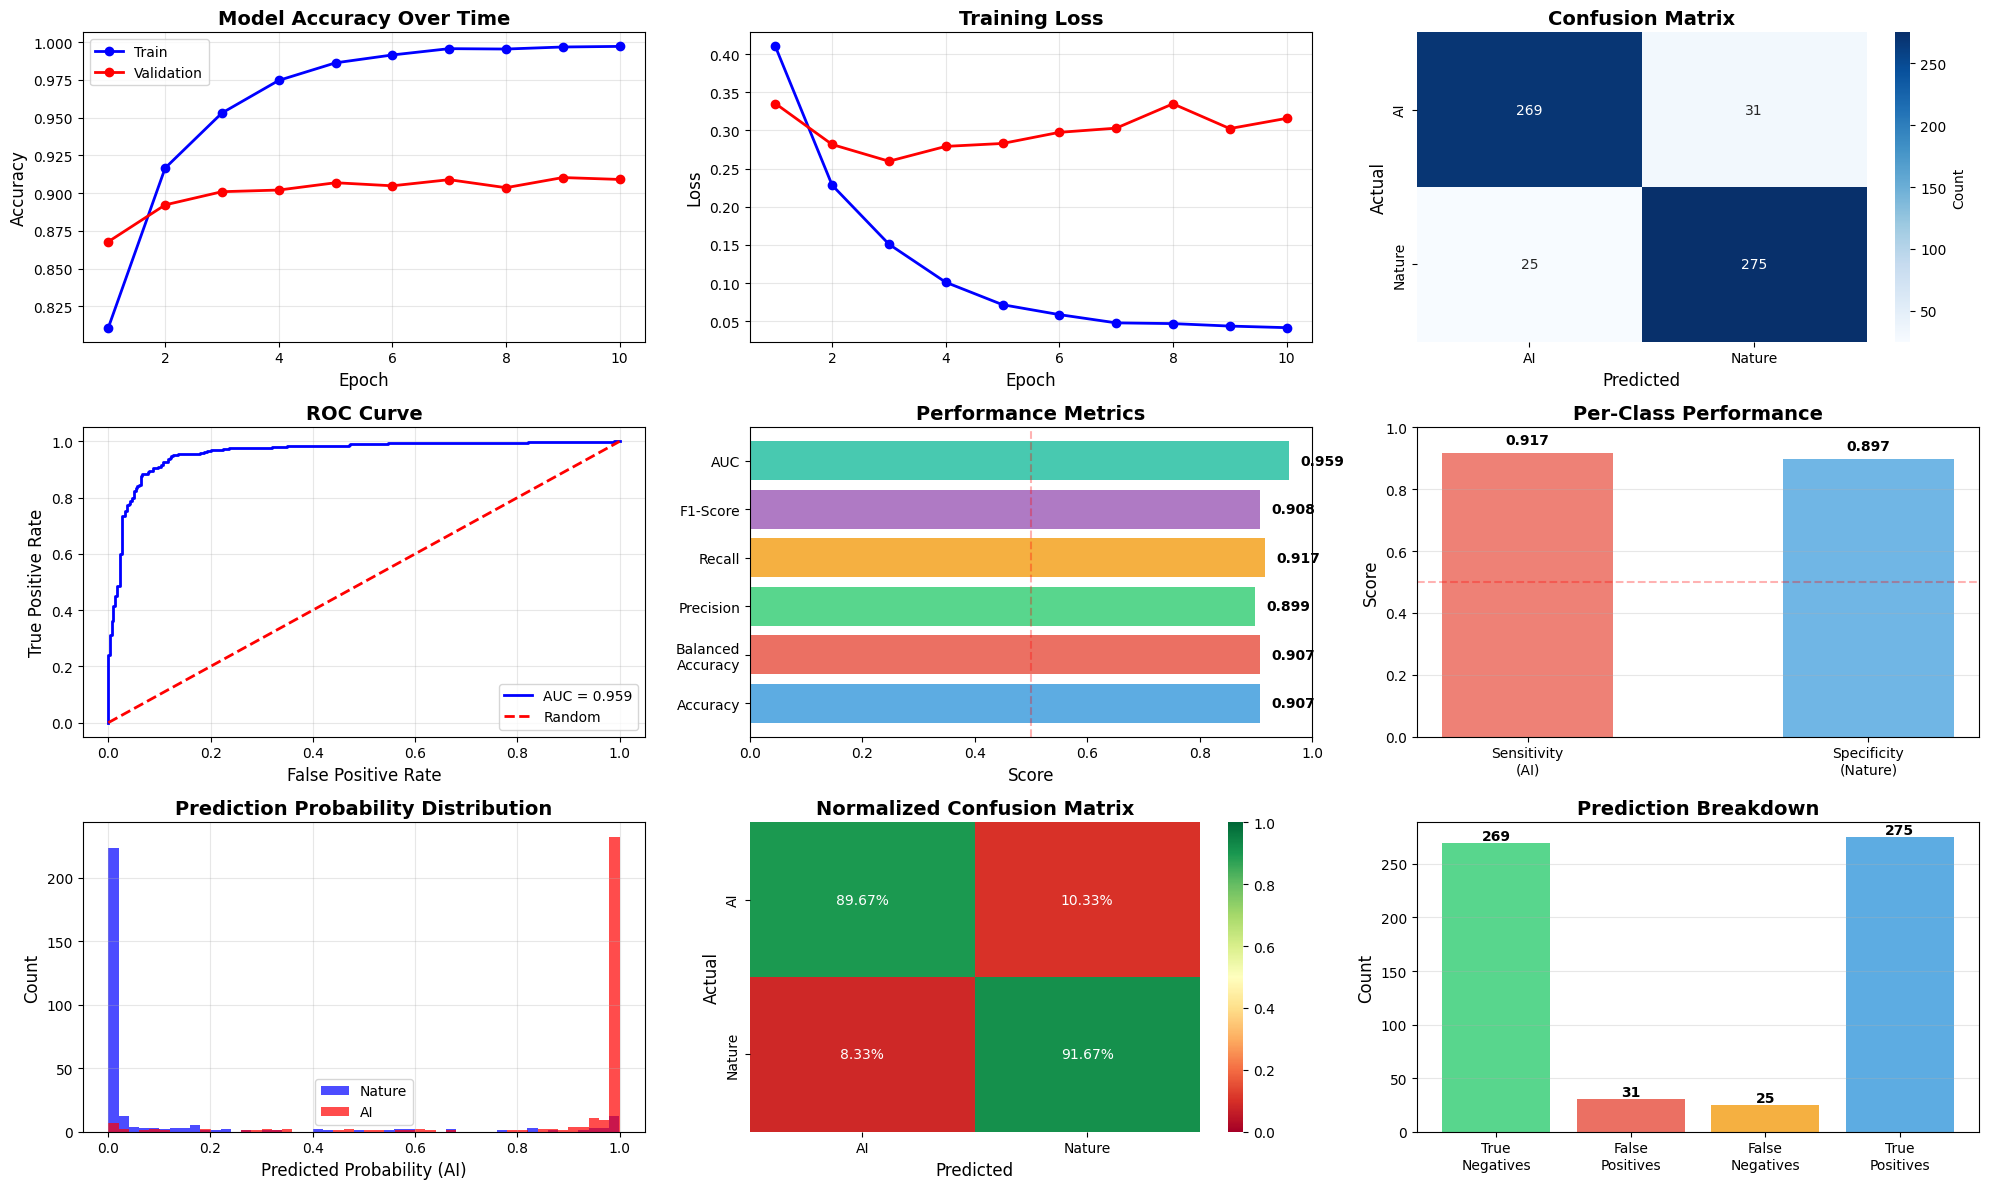

✓ Visualizations saved!


In [ ]:
# ============================================
# VISUALIZATIONS
# ============================================

# print("\n📊 Creating visualizations...")

fig = plt.figure(figsize=(20, 12))

# # 1. Training History
ax1 = plt.subplot(3, 3, 1)
epochs_range = range(1, epochs + 1)
ax1.plot(epochs_range, train_accs, 'b-o', label='Train', linewidth=2)
ax1.plot(epochs_range, val_accs, 'r-o', label='Validation', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

 # 2. Loss Curve
ax2 = plt.subplot(3, 3, 2)
ax2.plot(epochs_range, train_losses, 'b-o', linewidth=2)
ax2.plot(epochs_range, val_losses, 'r-o', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss', fontsize=12)
ax2.set_title('Training Loss', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

# # 3. Confusion Matrix
ax3 = plt.subplot(3, 3, 3)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
              xticklabels=['AI', 'Nature'],
              yticklabels=['AI', 'Nature'],
              cbar_kws={'label': 'Count'})
ax3.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
ax3.set_ylabel('Actual', fontsize=12)
ax3.set_xlabel('Predicted', fontsize=12)

# 4. ROC Curve
ax4 = plt.subplot(3, 3, 4)
fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
ax4.plot(fpr, tpr, 'b-', linewidth=2, label=f'AUC = {auc:.3f}')
ax4.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Metrics Bar Chart
ax5 = plt.subplot(3, 3, 5)
metrics_names = ['Accuracy', 'Balanced\nAccuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']
metrics_values = [accuracy, balanced_acc, precision, recall, f1, auc]
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']
bars = ax5.barh(metrics_names, metrics_values, color=colors, alpha=0.8)
ax5.set_xlim(0, 1)
ax5.set_xlabel('Score', fontsize=12)
ax5.set_title('Performance Metrics', fontsize=14, fontweight='bold')
ax5.axvline(x=0.5, color='red', linestyle='--', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, metrics_values)):
    ax5.text(val + 0.02, i, f'{val:.3f}', va='center', fontweight='bold')

# 6. Per-Class Performance
ax6 = plt.subplot(3, 3, 6)
class_metrics = ['Sensitivity\n(AI)', 'Specificity\n(Nature)']
class_values = [sensitivity, specificity]
class_colors = ['#e74c3c', '#3498db']
bars = ax6.bar(class_metrics, class_values, color=class_colors, alpha=0.7, width=0.5)
ax6.set_ylim(0, 1)
ax6.set_ylabel('Score', fontsize=12)
ax6.set_title('Per-Class Performance', fontsize=14, fontweight='bold')
ax6.axhline(y=0.5, color='red', linestyle='--', alpha=0.3)
for bar, val in zip(bars, class_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

# 7. Prediction Distribution
ax7 = plt.subplot(3, 3, 7)
ax7.hist(all_probabilities[all_labels == 0], bins=50, alpha=0.7, label='Nature', color='blue')
ax7.hist(all_probabilities[all_labels == 1], bins=50, alpha=0.7, label='AI', color='red')
ax7.set_xlabel('Predicted Probability (AI)', fontsize=12)
ax7.set_ylabel('Count', fontsize=12)
ax7.set_title('Prediction Probability Distribution', fontsize=14, fontweight='bold')
ax7.legend()
ax7.grid(True, alpha=0.3)

# 8. Normalized Confusion Matrix
ax8 = plt.subplot(3, 3, 8)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn', ax=ax8,
            xticklabels=['AI', 'Nature'],
            yticklabels=['AI', 'Nature'],
            vmin=0, vmax=1)
ax8.set_title('Normalized Confusion Matrix', fontsize=14, fontweight='bold')
ax8.set_ylabel('Actual', fontsize=12)
ax8.set_xlabel('Predicted', fontsize=12)

# 9. Error Analysis
ax9 = plt.subplot(3, 3, 9)
error_types = ['True\nNegatives', 'False\nPositives', 'False\nNegatives', 'True\nPositives']
error_counts = [tn, fp, fn, tp]
error_colors = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']
bars = ax9.bar(error_types, error_counts, color=error_colors, alpha=0.8)
ax9.set_ylabel('Count', fontsize=12)
ax9.set_title('Prediction Breakdown', fontsize=14, fontweight='bold')
for bar, val in zip(bars, error_counts):
    height = bar.get_height()
    ax9.text(bar.get_x() + bar.get_width()/2., height,
            f'{val}', ha='center', va='bottom', fontweight='bold')
ax9.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/AI_vs_human/model_binary_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations saved!")

# 11. Download the model from hugging face repository
model url = https://huggingface.co/gechen98/AI_image_classification/tree/main



In [ ]:
# Download the model from hugging face mode repository
from transformers import ViTForImageClassification
# Binary classification model
model = ViTForImageClassification.from_pretrained(
    "gechen98/AI_image_classification"
)

print("Loaded successfully")

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

Loaded successfully


In [ ]:
# put the model to gpu if you are using GPU
model.to(DEVICE)